# DeepFool ATTACK

In [1]:
# !pip install facenet-pytorch
# !pip install Pillow
# !pip install -q tensorflow==2.0.0
# !pip install adversarial-robustness-toolbox[all]
# !pip install matplotlib

### *Import*



### initialization

In [16]:
import os
import re
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
import torch
from torch.nn import CrossEntropyLoss
import torch.nn as nn
from art.estimators.classification import PyTorchClassifier
import tensorflow as tf
from matplotlib import pyplot as plt
from utils import load_test_image_NN2_preprocessed

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = str(device)
print(device)

/Users/danieleabbagnale/Desktop/AI CyberSecurity/Face_Recognition_Security/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


cpu


In [17]:
if device in 'cuda':
    print("Import Inception.Inception")
    import inception
    nn1 = inception.InceptionResnetV1(pretrained='vggface2').eval()
    nn1 .classify = True
elif device == "cpu":
    print("Import Facenet.Inception")
    from facenet_pytorch import InceptionResnetV1
    nn1  = InceptionResnetV1(pretrained='vggface2').eval()
    nn1.classify = True

nn1.to(device)

model_nn1 = PyTorchClassifier(nn1,input_shape=[160,160], loss=CrossEntropyLoss(),nb_classes=8631, device_type=device) #This class implements a classifier with the PyTorch framework.


Import Facenet.Inception


In [18]:
from RESNET import ResNet
from utils import get_labels
from utils import load_state_dict

nn2 = ResNet.resnet50(num_classes=8631, include_top=True)


load_state_dict(nn2,'resnet50_scratch_weight.pkl')
nn2.eval()

model_nn2 = PyTorchClassifier(nn2,input_shape=[224,224], loss=CrossEntropyLoss(),nb_classes=8631, device_type=device)

LABELS = get_labels()

### Untargeted Attack on all test set

In [ ]:
from art.attacks.evasion import DeepFool
import os
import re
import numpy as np
from utils import load_image_NN1, load_test_image_NN2

dataset_dir = "test_set_cropped/"
#eps_step =[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9]
eps_step =[0.000005, 0.00001, 0.00015, 0.002, 0.025, 0.03, 0.35, 0.4, 0.45, 0.5, 1, 2, 5, 8]
max_iter = [1,5]


accuracy_for_eps_nn1 = np.zeros((len(max_iter),len(eps_step)))
perturbation_for_eps_nn1 = np.zeros((len(max_iter),len(eps_step)))
correct_predictions_nn1 = 0

accuracy_for_eps_nn2 = np.zeros((len(max_iter),len(eps_step)))
perturbation_for_eps_nn2 = np.zeros((len(max_iter),len(eps_step)))
correct_predictions_nn2 = 0

accuracy_for_eps_nn2_preprocessed=np.zeros((len(max_iter),len(eps_step)))
correct_predictions_nn2_preprocessed=0


total_images = 0
print("Inizio Attacco DeepFool NON-TARGETED")

# Ensure models and labels are defined and loaded
# model_nn1, model_nn2, LABELS should be defined here
for i in range(len(max_iter)):
    for j in range(len(eps_step)):
        correct_predictions_nn1 = 0
        correct_predictions_nn2 = 0
        correct_predictions_nn2_preprocessed=0
        total_images = 0

        perturbations = []
        attack = DeepFool(classifier=model_nn1, epsilon=eps_step[j], max_iter=max_iter[i])

        print(f"**** Attacco con eps: {eps_step[j]} ****")
        for filename in os.listdir(dataset_dir):
            if filename.endswith(".jpg") or filename.endswith(".jpeg"):
                person_path = os.path.join(dataset_dir, filename)
                test_img = load_image_NN1(person_path, device).numpy()
                test_images_adv = attack.generate(test_img)
                nn1_predictions = model_nn1.predict(test_images_adv)
                test_images_NN2 = load_test_image_NN2(test_images_adv)
                nn2_predictions = model_nn2.predict(test_images_NN2)

                test_images_NN2_preprocessed= load_test_image_NN2_preprocessed(test_images_adv)
                nn2_prediction_preprocessed=model_nn2.predict(test_images_NN2_preprocessed)

                correct_label = re.sub(r'_\d+_face_0\.jpg$', '', filename)
                perturbations.append(np.linalg.norm(test_images_adv - test_img))

                predicted_label_nn1 = LABELS[np.array(nn1_predictions.argmax())]
                predicted_label_nn2 = LABELS[np.array(nn2_predictions.argmax())]
                predicted_label_nn2_preprocessed= LABELS[np.array(nn2_prediction_preprocessed.argmax())]

                total_images += 1

                if correct_label in predicted_label_nn1:
                    correct_predictions_nn1 += 1

                if correct_label in predicted_label_nn2:
                     correct_predictions_nn2 += 1

                if correct_label in predicted_label_nn2_preprocessed:
                     correct_predictions_nn2_preprocessed +=1
                
                if total_images == 500:
                    print("SEI A 500 IMMAGINI PER max_iter: {} e eps: {}".format(max_iter[i],eps_step[j]))
        if total_images != 0:
            perturbation_mean = np.mean(perturbations)
            perturbation_for_eps_nn1[i][j]=perturbation_mean
        
            accuracy_nn1 = correct_predictions_nn1 / total_images
            accuracy_for_eps_nn1[i][j]=accuracy_nn1

            accuracy_nn2 = correct_predictions_nn2/ total_images
            accuracy_for_eps_nn2[i][j]=accuracy_nn2

            accuracy_nn2_preprocessed= correct_predictions_nn2_preprocessed/total_images
            accuracy_for_eps_nn2_preprocessed[i][j]=accuracy_nn2_preprocessed

            print(f"Accuracy Inception ResNet for eps {eps_step[j]}: {accuracy_nn1}")
            print(f"Accuracy Resnet50 for eps {eps_step[j]}: {accuracy_nn2}")
            print(f"Average perturbation for eps {eps_step[j]}: {perturbation_mean}")


In [16]:
print(perturbation_for_eps_nn1)

[[0.79307044 0.79307473 0.79318601 0.79465318 0.81289381 0.81685913
  1.07064068 1.11029398 1.14994729 1.18960071 1.58613431 2.37920141
  4.75840282 7.13760424]
 [0.90827721 0.90830296 0.90841991 0.91010672 0.93098825 0.93554956
  1.22619045 1.27160978 1.31700742 1.36244023 1.81658804 2.72485018
  5.4497261  8.17453671]]


In [6]:
print(eps_step)

print(accuracy_for_eps_nn1)
print("\n")
print(accuracy_for_eps_nn2)
print("\n")
print(accuracy_for_eps_nn2_preprocessed)

[5e-06, 1e-05, 0.00015, 0.002, 0.025, 0.03, 0.35, 0.4, 0.45, 0.5, 1, 2, 5, 8]
[[0.191 0.191 0.191 0.191 0.185 0.184 0.105 0.095 0.083 0.074 0.035 0.017
  0.01  0.009]
 [0.023 0.023 0.023 0.023 0.021 0.021 0.015 0.015 0.014 0.014 0.01  0.01
  0.008 0.007]]


[[0.858 0.858 0.858 0.858 0.856 0.856 0.84  0.835 0.831 0.828 0.774 0.689
  0.425 0.298]
 [0.854 0.854 0.854 0.854 0.852 0.852 0.835 0.831 0.827 0.824 0.768 0.651
  0.339 0.219]]


[[0.904 0.904 0.904 0.904 0.903 0.903 0.894 0.892 0.892 0.888 0.862 0.79
  0.543 0.375]
 [0.903 0.903 0.903 0.903 0.902 0.902 0.894 0.892 0.892 0.888 0.861 0.776
  0.469 0.29 ]]


In [8]:
import numpy as np

accuracy_nn1 = [[0.191, 0.191, 0.191, 0.191, 0.185, 0.184, 0.105, 0.095, 0.083, 0.074, 0.035, 0.017,
  0.01,  0.009],
 [0.023, 0.023, 0.023, 0.023, 0.021, 0.021, 0.015, 0.015, 0.014, 0.014, 0.01,  0.01,
  0.008, 0.007]]

accuracy_nn2 = [[0.858, 0.858, 0.858, 0.858, 0.856, 0.856, 0.84,  0.835, 0.831, 0.828, 0.774, 0.689, 0.425, 0.298],
 [0.854, 0.854, 0.854, 0.854, 0.852, 0.852, 0.835, 0.831, 0.827, 0.824, 0.768, 0.651, 0.339, 0.219]]

accuracy_for_eps_nn2_preprocessed = [[0.904, 0.904, 0.904, 0.904, 0.903, 0.903, 0.894, 0.892, 0.892, 0.888 ,0.862, 0.79,
  0.543, 0.375],
 [0.903, 0.903, 0.903, 0.903, 0.902, 0.902, 0.894, 0.892, 0.892, 0.888, 0.861, 0.776,
  0.469, 0.29 ]]

eps_step =[0.000005, 0.00001, 0.00015, 0.002, 0.025, 0.03, 0.35, 0.4, 0.45, 0.5, 1, 2, 5, 8]
max_iter = [1,5]


#### SECURITY EVALUATION CURVE NN1

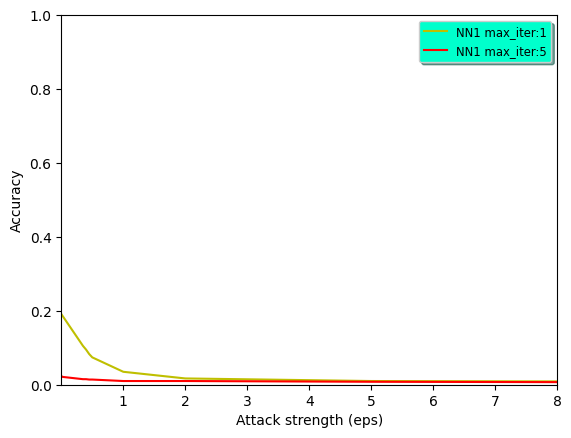

In [9]:
from matplotlib import pyplot as plt

# plot accuracy/Attack strength NN1-NN2

fig, ax = plt.subplots()

ax.plot(np.array(eps_step), np.array(accuracy_for_eps_nn1[0]), 'y-', label='NN1 max_iter:{}'.format(max_iter[0]))
ax.plot(np.array(eps_step), np.array(accuracy_for_eps_nn1[1]), 'r-', label='NN1 max_iter:{}'.format(max_iter[1]))


legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
legend.get_frame().set_facecolor('#00FFCC')

ax.set_xlim(eps_step[0], eps_step[-1])  # Imposta i limiti dell'asse x
ax.set_ylim(0,1)  # Imposta i limiti dell'asse y
plt.xlabel('Attack strength (eps)')
plt.ylabel('Accuracy')

plt.show()

#### ACCURACY/PERTURBAZIONE NN1

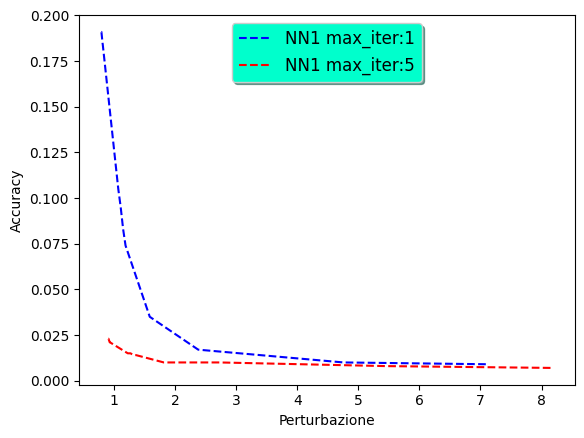

In [29]:
fig, ax = plt.subplots()
ax.plot(np.array(perturbation_for_eps_nn1[0]),accuracy_for_eps_nn1[0], 'b--', label='NN1 max_iter:{}'.format(max_iter[0]))
ax.plot (np.array(perturbation_for_eps_nn1[1]),accuracy_for_eps_nn1[1], 'r--', label='NN1 max_iter:{}'.format(max_iter[1]))
legend = ax.legend(loc='upper center', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#00FFCC')

plt.ylabel('Accuracy')
plt.xlabel('Perturbazione')
plt.show()

#### EVALUATION CURVE NN2 PREPROCESSED

In [ ]:
# plot accuracy/Attack strength NN1-NN2

fig, ax = plt.subplots()

ax.plot(np.array(eps_step), np.array(accuracy_for_eps_nn2_preprocessed[0]), 'g--', label='NN2 Prep. max_iter:{}'.format(max_iter[0]))
ax.plot(np.array(eps_step), np.array(accuracy_for_eps_nn2_preprocessed[1]), 'm--', label='NN2 Prep. max_iter:{}'.format(max_iter[1]))

legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
legend.get_frame().set_facecolor('#00FFCC')

ax.set_xlim(eps_step[0], eps_step[-1])  # Imposta i limiti dell'asse x
ax.set_ylim(0,1)  # Imposta i limiti dell'asse y
plt.xlabel('Attack strength (eps)')
plt.ylabel('Accuracy')

#### CONFRONTO NN1 e NN2

Text(0.5, 0, 'Learning Rate')

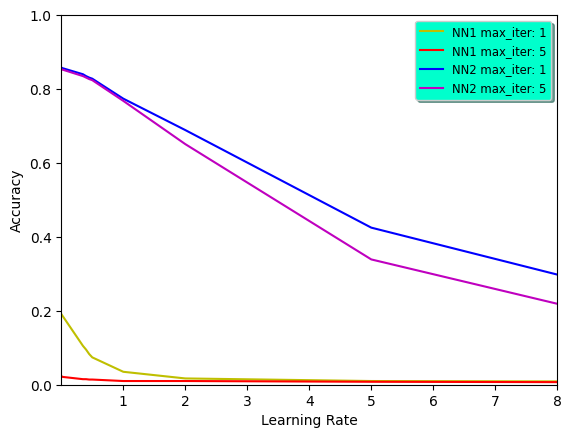

In [12]:
fig, ax = plt.subplots()
ax.plot(eps_step, np.array(accuracy_for_eps_nn1[0]), 'y-', label='NN1 max_iter: 1')
ax.plot(eps_step, np.array(accuracy_for_eps_nn1[1]), 'r-', label='NN1 max_iter: 5')
ax.plot(eps_step, np.array(accuracy_for_eps_nn2[0]), 'blue', label='NN2 max_iter: 1')
ax.plot(eps_step, np.array(accuracy_for_eps_nn2[1]), 'm-', label='NN2 max_iter: 5')


legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
legend.get_frame().set_facecolor('#00FFCC')
ax.set_xlim(eps_step[0], eps_step[-1])  # Imposta i limiti dell'asse x
ax.set_ylim(0,1)  # Imposta i limiti dell'asse y
plt.ylabel('Accuracy')
plt.xlabel('Learning Rate')

#### CONFRONTO MAX ATTACK NN1 NN2 NN2Prep.


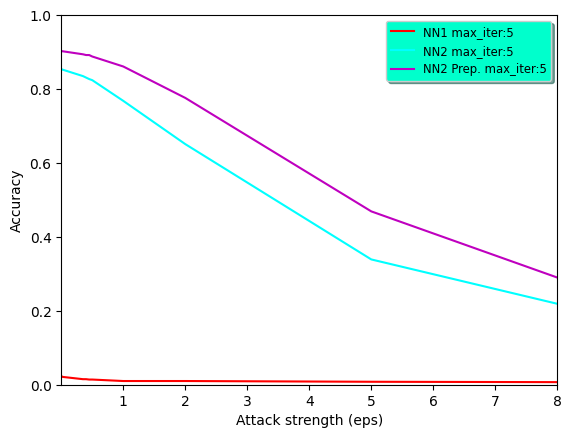

In [14]:
from matplotlib import pyplot as plt
# plot accuracy/Attack strength NN1-NN2

fig, ax = plt.subplots()


ax.plot(np.array(eps_step), np.array(accuracy_for_eps_nn1[1]), 'r-', label='NN1 max_iter:{}'.format(max_iter[1]))
ax.plot(np.array(eps_step), np.array(accuracy_for_eps_nn2[1]), 'cyan', label='NN2 max_iter:{}'.format(max_iter[1]))
ax.plot(np.array(eps_step), np.array(accuracy_for_eps_nn2_preprocessed[1]), 'm-', label='NN2 Prep. max_iter:{}'.format(max_iter[1]))


legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
legend.get_frame().set_facecolor('#00FFCC')

ax.set_xlim(eps_step[0], eps_step[-1])  # Imposta i limiti dell'asse x
ax.set_ylim(0,1)  # Imposta i limiti dell'asse y
plt.xlabel('Attack strength (eps)')
plt.ylabel('Accuracy')

plt.show()

### Single sample Untargeted attack

In [40]:
from art.attacks.evasion import DeepFool

epsilon = 8
max_iter = 5

attack = DeepFool(classifier=model_nn1, epsilon=epsilon, max_iter=max_iter)

In [41]:
from utils import load_image_NN1, load_test_image_NN2, load_test_image_NN2_preprocessed
import os
import numpy as np



dataset_dir = "test_set_cropped/"
filename = "Brad_Pitt_5_face_0.jpg"
person_path = os.path.join(dataset_dir, filename)

test_img = load_image_NN1(person_path,device)
test_img_numpy = test_img.numpy()
test_images_adv = attack.generate(test_img_numpy)


nn1_predictions = model_nn1.predict(test_images_adv)
perturbation = np.mean(np.abs((test_images_adv - test_img_numpy)))
print('Average perturbation: {:4.2f}'.format(perturbation))

test_image_nn2 = load_test_image_NN2(test_images_adv)

nn2_predictions = model_nn2.predict(test_image_nn2)

test_images_NN2_pre = load_test_image_NN2_preprocessed(test_images_adv)


nn2_predictions_pre = model_nn2.predict(test_images_NN2_pre)


predicted_label_nn1 = LABELS[np.array(nn1_predictions.argmax())]
predicted_label_nn2 = LABELS[np.array(nn2_predictions.argmax())]
predicted_label_nn2_pre = LABELS[np.array(nn2_predictions_pre.argmax())]
print("NN1{} con probabilità {}".format(predicted_label_nn1,nn1_predictions[0][nn1_predictions.argmax()]))
print("NN2{} con probabilità {}".format(predicted_label_nn2,nn2_predictions[0][nn2_predictions.argmax()]))
print("NN2{} con probabilità {}".format(predicted_label_nn2_pre,nn2_predictions_pre[0][nn2_predictions_pre.argmax()]))


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.08s/it]

Average perturbation: 0.02
NN1 Ronn_Moss con probabilità 12.298135757446289
NN2 Ronn_Moss con probabilità 11.761774063110352
NN2 Brad_Pitt con probabilità 12.94464111328125


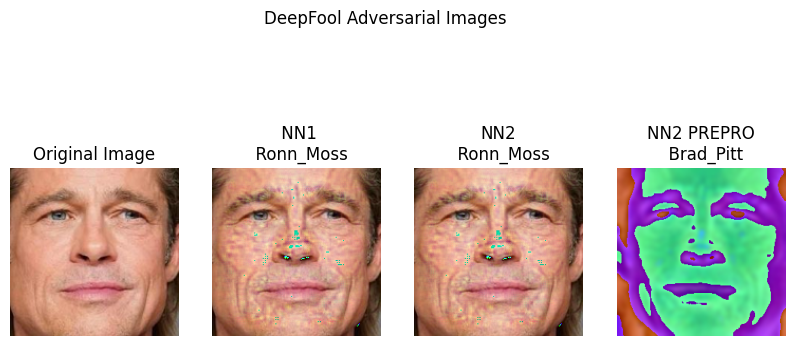

In [42]:
# Converti le immagini in uint8 per la visualizzazione
if test_img_numpy.dtype != np.uint8:
    test_img_numpy = (test_img_numpy * 255).astype(np.uint8)
    test_img_numpy = np.squeeze(test_img_numpy, axis=0)  # Rimuovi la dimensione batch extra
    test_img_numpy = np.transpose(test_img_numpy, (1, 2, 0))


# Prepara le immagini per la visualizzazione
# Rimuovi la dimensione batch extra e converti nel formato channels-last
test_images_adv = np.squeeze(test_images_adv, axis=0)
test_images_adv = np.transpose(test_images_adv, (1, 2, 0))

if test_images_adv.dtype != np.uint8:
    test_images_adv = (test_images_adv * 255).astype(np.uint8)

test_images_NN2_pre = test_images_NN2_pre.numpy()

test_images_NN2_pre = np.squeeze(test_images_NN2_pre, axis=0)
test_images_NN2_pre = np.transpose(test_images_NN2_pre, (1, 2, 0))

if test_images_NN2_pre.dtype != np.uint8:
    test_images_NN2_pre = (test_images_NN2_pre * 255).astype(np.uint8)

# Visualizza le immagini affiancate con Matplotlib
fig, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(10, 5))

# Mostra l'immagine originale
ax1.imshow(test_img_numpy)
ax1.set_title('Original Image')
ax1.axis('off')

# Mostra l'immagine avversaria
ax2.imshow(test_images_adv)
ax2.set_title(f' NN1\n {predicted_label_nn1}')
ax2.axis('off')

ax3.imshow(test_images_adv)
ax3.set_title(f'NN2\n {predicted_label_nn2}')
ax3.axis('off')

ax4.imshow(test_images_NN2_pre)
ax4.set_title(f'NN2 PREPRO\n {predicted_label_nn2_pre}')
ax4.axis('off')

# Mostra la figura
plt.suptitle("DeepFool Adversarial Images")
plt.show()